<div style="display:block">
    <div >
        <h5  style="color:#4780B2; text-align: center; font-size:25px;">PyTorch 101 for Vision Machine Learning</h5>
        <div style="width: 90%; text-align: center; display: inline-block;"><i>Author: </i> <strong>Shubhra Prakash</strong> 
            <br>  <div style=" text-align: right;"><i>Modified: Dec 28th, 2022</i></div>
        </div>
    </div>
</div>

# Objectives

* Train a number detection model for MNIST Dataset
* Solve the following problem: Write a neural network that can:

1. take 2 inputs:
    1. an image from the MNIST dataset (say 5), and
    2. a random number between 0 and 9, (say 7)
2. and gives two outputs:
    1. the "number" that was represented by the MNIST image (predict 5), and
    2. the "sum" of this number with the random number and the input image to the network (predict 5 + 7 = 12)
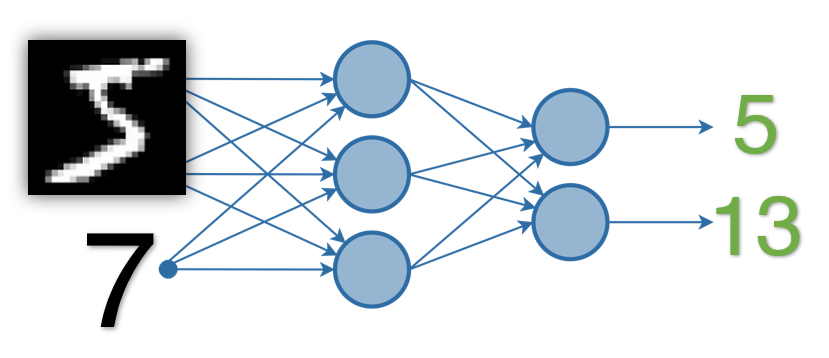   
3. you can mix fully connected layers and convolution layers
4. you can use one-hot encoding to represent the random number input and the "summed" output.
5. Random number (7) can be represented as 0 0 0 0 0 0 0 1 0 0
6. Sum (13) can be represented as:
    7. 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0



# Importing Libraries

Importing the necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#import MNIST dataset
from torchvision.datasets import MNIST

#import data loader and dataset
from torch.utils.data import DataLoader,Dataset

from torchvision.utils import make_grid
from tqdm import tqdm

# imports random module
import random

In [2]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

In [3]:
# Checking if Cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# HyperParameters

In [4]:
#define hyperparameters
batch_size = 100
num_epochs = 10
learning_rate = 0.01

# Adding Dataset

In [5]:
#load the MNIST dataset
train_dataset = MNIST(root='data/',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = MNIST(root='data/',train=False,transform=transforms.ToTensor(),download=True)

#create data loaders
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

## Exploring Datasets

In [6]:
print(f"Train Size:{len(train_dataset)},Test Size:{len(test_dataset)}")

Train Size:60000,Test Size:10000


## Class Distribution

In [7]:
def plot_distribution_classes(x_values, y_values):
    # Figure Size
    fig = plt.figure(figsize =(10, 7))

    # Horizontal Bar Plot
    plt.bar(x_values,y_values)

    # Show Plot
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title("Distribution of classes")
    fig.show()

In [8]:
print(train_dataset.targets)
print(train_dataset.targets.bincount())

tensor([5, 0, 4,  ..., 5, 6, 8])
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


### Train Data

C:\Users\shubh\AppData\Local\Temp\ipykernel_16876\3192017234.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


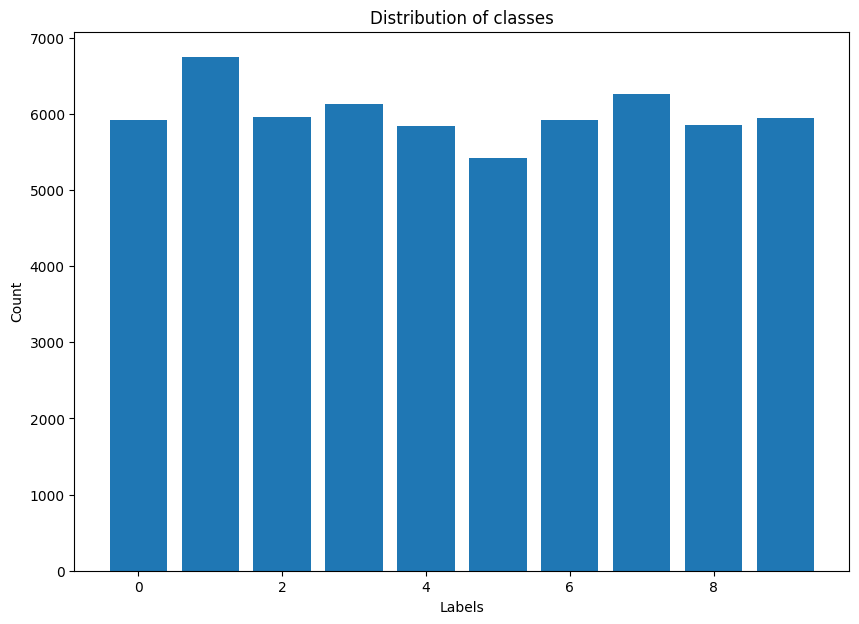

In [9]:
x = np.sort(train_dataset.targets.unique())
y = train_dataset.targets.bincount()

plot_distribution_classes(x, y)

In [10]:
print(test_dataset.targets)
print(test_dataset.targets.bincount())

tensor([7, 2, 1,  ..., 4, 5, 6])
tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


## Visualizing Images

labels: tensor([0, 8, 3, 6, 2, 6, 4, 6, 9, 8, 8, 2, 3, 0, 8, 0, 3, 0, 0, 0, 5, 9, 7, 8, 6, 4, 7, 3, 4, 0, 7, 9, 7, 6, 7, 2, 9,
        5, 9, 9, 7, 1, 4, 5, 5, 5, 0, 6, 0, 0, 8, 3, 5, 3, 7, 8, 3, 5, 8, 1, 0, 0, 7, 6, 1, 1, 3, 5, 0, 6, 8, 6, 0, 3,
        0, 1, 6, 6, 1, 1, 2, 0, 2, 4, 9, 2, 8, 1, 2, 2, 8, 2, 1, 4, 8, 9, 3, 8, 5, 0])


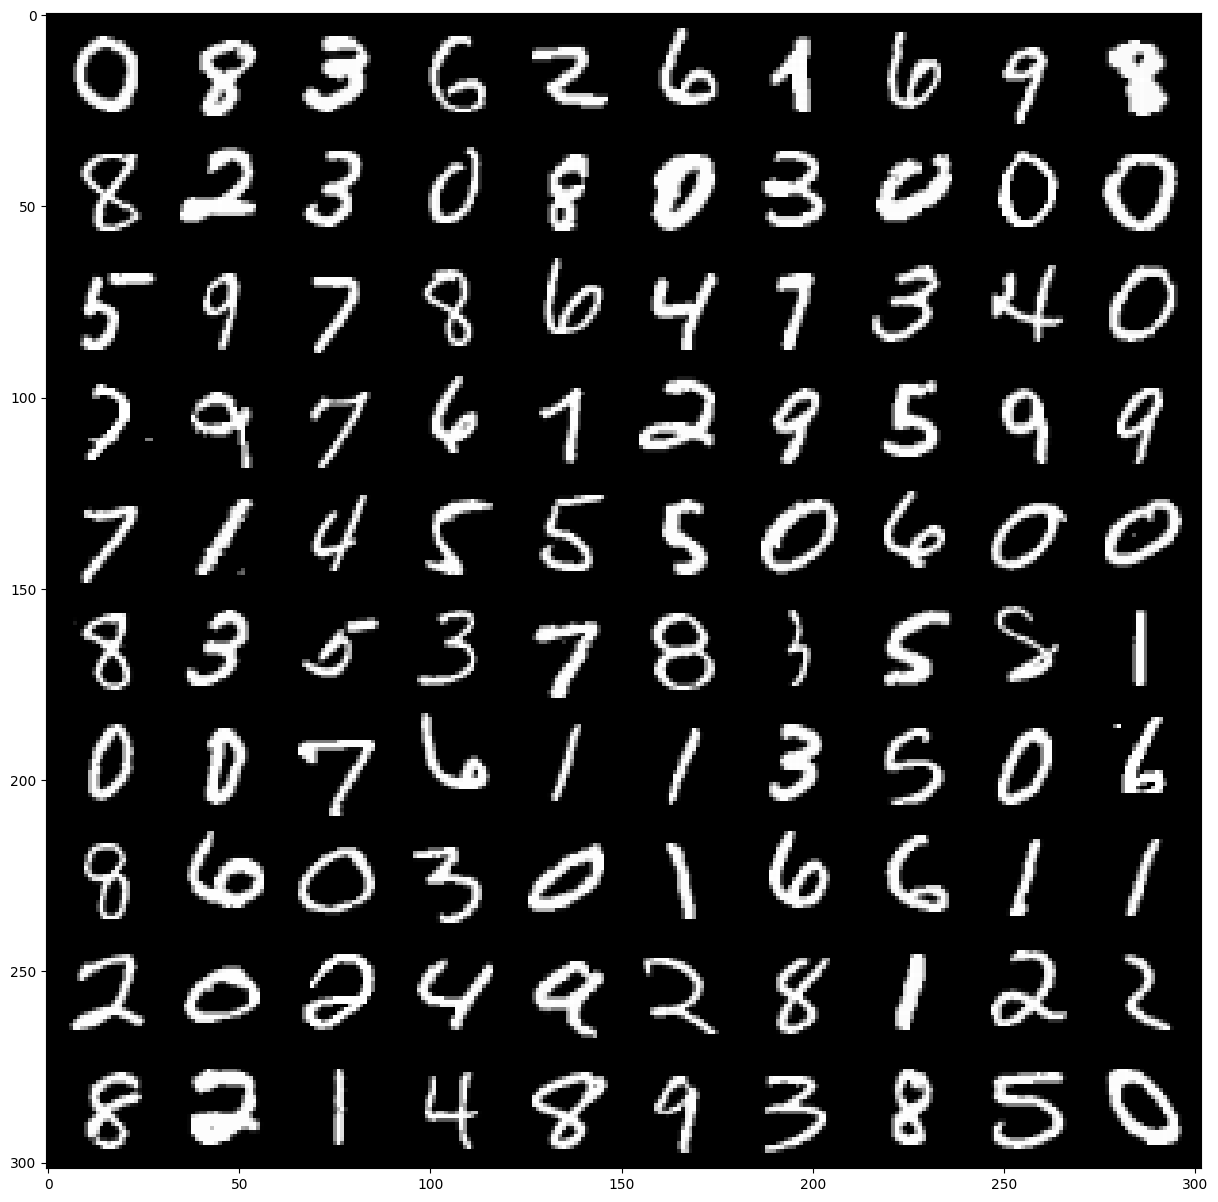

In [11]:
batch = next(iter(train_loader))
images, labels = batch

grid = make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

# Define Model1

## Writing/Testing the MNIST Classifier

In [12]:
#define a convolutional neural network

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
  
    def forward(self, t):
        # input layer
        x = t

        # conv1 layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

        # conv2 layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

        # reshapre
        x = x.reshape(-1, 12 * 4 * 4)

        # fc1 layer
        x = self.fc1(x)
        x = F.relu(x)

        # fc2 layer
        x = self.fc2(x)
        x = F.relu(x)

        # output layer
        x = self.out(x)
        # x = F.softmax(x, dim=1)
        return x

In [13]:
#instantiate the model
network = Network().to(device)
# network = Network()

In [14]:
#define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(),lr=learning_rate)

In [15]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [16]:
%%time
#train the model
for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data,target) in enumerate(tepoch):
            #forward pass
            data, target = data.to(device), target.to(device)
            output = network(data)
            loss = criterion(output,target)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += get_num_correct(output, target)

        print(
            "epoch", epoch, 
            "total_correct:", total_correct, 
            "loss:", total_loss
        )

100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:20<00:00, 29.42batch/s]


epoch 0 total_correct: 56291 loss: 114.16726806620136


100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.61batch/s]


epoch 1 total_correct: 58727 loss: 45.04257546173176


100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 31.35batch/s]


epoch 2 total_correct: 58974 loss: 36.20118549373001


100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.50batch/s]


epoch 3 total_correct: 59045 loss: 35.673317799170036


100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 31.11batch/s]


epoch 4 total_correct: 59016 loss: 35.771958319382975


100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 31.05batch/s]


epoch 5 total_correct: 59044 loss: 35.47070654819254


100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 27.10batch/s]


epoch 6 total_correct: 59161 loss: 32.57535854514572


100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.50batch/s]


epoch 7 total_correct: 59184 loss: 31.17094529467431


100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.71batch/s]


epoch 8 total_correct: 59250 loss: 28.468606110065593


100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 31.30batch/s]

epoch 9 total_correct: 59350 loss: 25.28766833408008
CPU times: total: 3min 23s
Wall time: 3min 19s


In [19]:
59350/60000

0.9891666666666666

In [20]:
# #test the model
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for data, target in test_loader:
#         output = network(data)
#         _, predicted = torch.max(output.data,1)
#         total += target.size(0)
#         correct += (predicted==target).sum().item()
        
#     print('Test Accuracy: {} %'.format(100*correct/total))

Test Accuracy: ~98.14 

# Define Model2 to find sum of image and Random number

## RandomNumber Dataset

In [21]:
# Creating a list of random number
rand_len=len(train_loader.dataset.targets)
rand_list=[random.randint(0, 9) for x in range(rand_len)]
print(f"Min:{min(rand_list)},Max:{max(rand_list)},Len:{len(rand_list)}")

Min:0,Max:9,Len:60000


### One Hot Encoding

In [22]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = rand_list
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded_num = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded_num)

[0 4 3 ... 1 3 7]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [ ]:
# onehot_encoded_num=[x.reshape(1,-1) for x in onehot_encoded_num]

In [23]:
onehot_encoded_num

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

### DataLoader for Random Number

In [24]:
class rand_num(Dataset):
    def __init__(self):
        self.x=torch.tensor(onehot_encoded_num,device="cuda", requires_grad=True, dtype=torch.float32)
        self.y=torch.tensor(rand_list,device="cuda")
        self.n_samples=len(self.y)
        
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.n_samples
    
dataset_num=rand_num()
train_loader_num=DataLoader(dataset=dataset_num,batch_size=batch_size,shuffle=True)

In [25]:
next(iter(train_loader_num))

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

In [26]:
#define a convolutional neural network

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120) # For images
        self.fc2 = nn.Linear(in_features=10, out_features=20) # For Number
        
        self.fc3 = nn.Linear(in_features=140, out_features=28) # Combination
        self.out_i = nn.Linear(in_features=28, out_features=10)
        self.out_rn = nn.Linear(in_features=28, out_features=18)
  
    def forward(self, t,rand_num_ohe):
        # input layer
        x = t#.to(device)
#         rand_num_ohe=rand_num_ohe.to(device)
#         rand_num_ohe=rand_num_ohe.reshape(1,-1)

        # conv1 layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

        # conv2 layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

        # reshapre
        x = x.reshape(-1, 12 * 4 * 4)

        # fc1 layer for images
        x = self.fc1(x)
        x = F.relu(x)
        
        # fc2 layer for rand_num_ohe
        x_r = self.fc2(rand_num_ohe)
        x_r = F.relu(x_r)
        
        #Concatenate the inputs 
#         print(x.shape)
        
#         print(x_r.shape)
        input_concat = torch.cat((x, x_r), dim=1)
        
        # fc2 layer for rand_num_ohe
        x_ir = self.fc3(input_concat)
        x_ir = F.relu(x_ir)

        # output layer
        x_image = self.out_i(x_ir)
        x_sum = self.out_rn(x_ir)
        # x = F.softmax(x, dim=1)
        return x_image,x_sum

In [27]:
network = Network().to("cuda")

print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=10, out_features=20, bias=True)
  (fc3): Linear(in_features=140, out_features=28, bias=True)
  (out_i): Linear(in_features=28, out_features=10, bias=True)
  (out_rn): Linear(in_features=28, out_features=18, bias=True)
)


In [28]:
for name, param in network.named_parameters():
    print(name, '\t\t', param.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([20, 10])
fc2.bias 		 torch.Size([20])
fc3.weight 		 torch.Size([28, 140])
fc3.bias 		 torch.Size([28])
out_i.weight 		 torch.Size([10, 28])
out_i.bias 		 torch.Size([10])
out_rn.weight 		 torch.Size([18, 28])
out_rn.bias 		 torch.Size([18])


# Training the model

In [29]:
#define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(),lr=learning_rate)

In [30]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [31]:
#train the model
for epoch in range(num_epochs):
    total_loss = 0
    total_correct_image = 0
    total_correct_num = 0
#     with tqdm(train_loader, unit="batch") as tepoch:
#     for batch_idx, (data_im,target_im) in enumerate(tepoch):
        #forward pass
#             data, target = data.to(device), target.to(device)
    for batch_image,batch_num in zip(train_loader,train_loader_num): # Get Batch
        images, labels_image = batch_image 
        rand_num_btch, labels_num = batch_num 
        #cuda
        images=images.to(device)
        labels_image =labels_image.to(device)
        
        rand_num_btch=rand_num_btch.to(device)
        labels_num=labels_num.to(device)
        
        sum_number=labels_image+labels_num
        
        
        output = network(images,rand_num_btch)
        loss1 = criterion(output[0],labels_image)
        loss2 = criterion(output[1],labels_num)
        total_loss = 0.8*(loss1) + 0.2*(loss2)

        #backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        total_loss += total_loss.item()
        total_correct_image += get_num_correct(output[0], labels_image)
        total_correct_num += get_num_correct(output[1], labels_num)

    print(
        "epoch", epoch, 
        "total_correct_image:", total_correct_image, 
        "total_correct_sum:", total_correct_num, 
        "loss:", total_loss
    )

epoch 0 total_correct_image: 55983 total_correct_sum: 55007 loss: tensor(0.2661, device='cuda:0', grad_fn=<AddBackward0>)
epoch 1 total_correct_image: 58575 total_correct_sum: 59995 loss: tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>)
epoch 2 total_correct_image: 58833 total_correct_sum: 59987 loss: tensor(0.2561, device='cuda:0', grad_fn=<AddBackward0>)
epoch 3 total_correct_image: 58936 total_correct_sum: 59919 loss: tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)
epoch 4 total_correct_image: 58971 total_correct_sum: 59927 loss: tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)
epoch 5 total_correct_image: 59070 total_correct_sum: 59931 loss: tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)
epoch 6 total_correct_image: 59050 total_correct_sum: 59912 loss: tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)
epoch 7 total_correct_image: 59125 total_correct_sum: 59940 loss: tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)
epoch 8 total_correct_im

In [ ]:
well documented (via readme file on GitHub and comments in the code)
must mention the data representation
must mention your data generation strategy (basically the class/method you are using for random number generation)
must mention how you have combined the two inputs (basically which layer you are combining)
must mention how you are evaluating your results 
must mention "what" results you finally got and how did you evaluate your results
must mention what loss function you picked and why!
training MUST happen on the GPU
Accuracy is not really important for the SUM